In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math
from sklearn.preprocessing import StandardScaler

In [2]:
segments = pd.read_csv("./../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUTS/merged_segements_10T.csv")
gps_data = pd.read_csv("./../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUTS/merged_gps_data_10T.csv")

In [3]:
# calculate norm for the route
positive = gps_data[gps_data['speed']>0]
norm_speed_mean = np.mean(gps_data['speed'])
norm_speed_std = np.std(gps_data['speed'])
norm_positive_acc_mean = np.mean(segments['average_acceleration'])
norm_negative_acc_mean = np.mean(segments['average_deacceleration'])
print(f"Mean of speed: {norm_speed_mean}")
print(f"Std of speed: {norm_speed_std}")
print(f"average positive acceleration: {norm_positive_acc_mean}")
print(f"average negative acceleration: {norm_negative_acc_mean}")

Mean of speed: 9.871590166204253
Std of speed: 7.083708139599793
average positive acceleration: 0.5049017275161105
average negative acceleration: -1.064966492304164


C:\Users\manda\AppData\Local\Temp\ipykernel_12848\4265082897.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color='red')


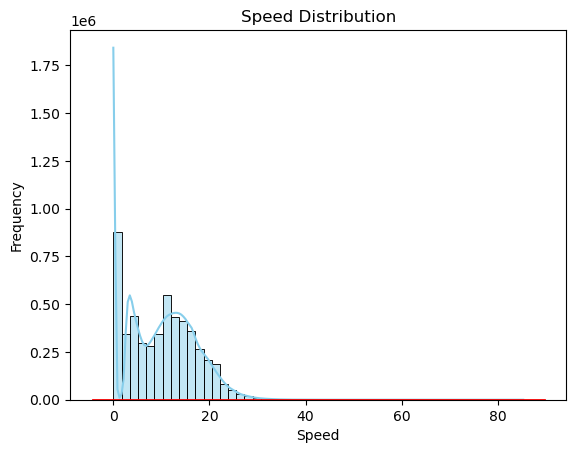

In [4]:
df = gps_data
# Plot a histogram
sns.histplot(df['speed'], kde=True, color='skyblue', bins=50)
plt.title('Speed Distribution')
plt.xlabel('Speed')
plt.ylabel('Frequency')

# Fit a normal distribution (bell curve) to the data
mu, std = df['speed'].mean(), df['speed'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color='red')

plt.show()

In [5]:
segs = segments.dropna()
segs.reset_index(drop=True, inplace=True)

In [6]:
segs['diff_speed_mean'] = segs['average_speed'] - norm_speed_mean
segs['diff_speed_std'] = np.sqrt(segs['speed_variation']) - norm_speed_std
segs['diff_acc_mean'] = segs['average_acceleration'] - norm_positive_acc_mean
segs['diff_neg_acc_mean'] = -segs['average_deacceleration'] - norm_negative_acc_mean

C:\Users\manda\AppData\Local\Temp\ipykernel_12848\417491193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segs['diff_speed_mean'] = segs['average_speed'] - norm_speed_mean
C:\Users\manda\AppData\Local\Temp\ipykernel_12848\417491193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segs['diff_speed_std'] = np.sqrt(segs['speed_variation']) - norm_speed_std
C:\Users\manda\AppData\Local\Temp\ipykernel_12848\417491193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [7]:
features = segs[['diff_speed_mean', 'diff_speed_std', 'diff_acc_mean', 'diff_neg_acc_mean']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))


[0.57835964 0.22669437]
0.8050540127948679


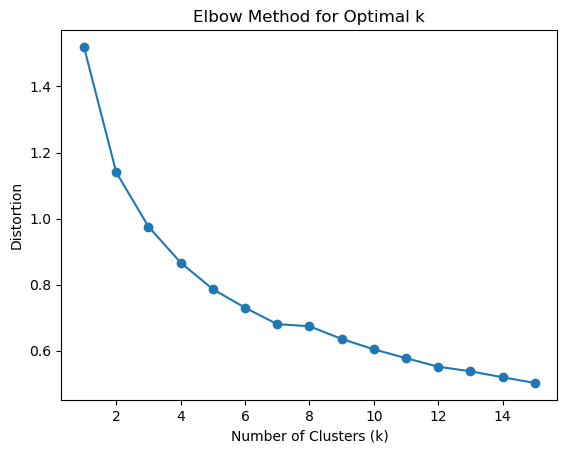

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def elbow_method(data, max_k=15):
    """
    Apply the elbow method to determine the optimal number of clusters for K-means.

    Parameters:
    - data: The input data for clustering.
    - max_k: The maximum number of clusters to consider.

    Returns:
    - Elbow plot to visualize the distortion for different values of k.
    """
    distortions = []

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
        kmeans.fit(data)
        distortions.append(sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

    # Plot the elbow curve
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.show()


elbow_method(principal_components)


In [24]:
# outlier removal
filterd_pca_results = principal_components[(principal_components[:,0]<10) & (principal_components[:,1]<10)]

In [45]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_kmeans(data, k):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # Silhouette Score
    # silhouette = silhouette_score(data, cluster_labels)

    # Davies-Bouldin Index
    db = davies_bouldin_score(data, cluster_labels)

    # print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Index: {db}")

    return kmeans

# Example usage:
# Assuming 'your_data' is the DataFrame or array you want to cluster
# and you want to perform K-means clustering with K=3
kmeans = evaluate_kmeans(principal_components, k=4)
labels = kmeans.labels_


Davies-Bouldin Index: 0.941193492374207


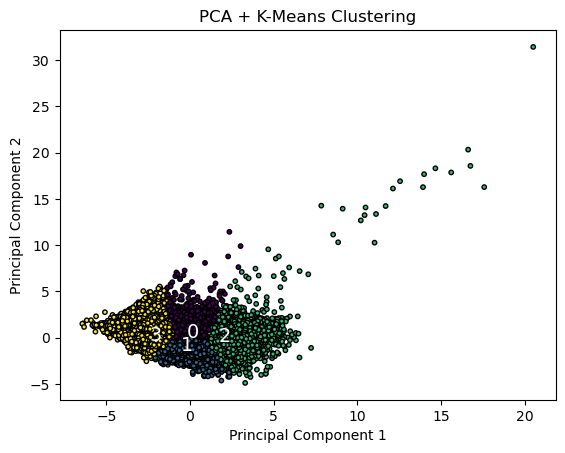

In [50]:

# plt.scatter(principal_components[:,0], principal_components[:,1], c=labels, cmap='viridis', marker='o', s=10, edgecolors='k')
# plt.title('PCA + K-Means Clustering')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', marker='o', s=10, edgecolors='k')

centers = kmeans.cluster_centers_
# Add cluster labels to each point
for i in range(0,len(centers)) :
    plt.text(centers[i, 0], centers[i, 1], str(i), fontsize=14, ha='center', va='center', c='white')

plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [35]:
segs['pc1'] = principal_components[:,0]
segs['pc2'] = principal_components[:,1]
segs['label'] = labels

C:\Users\manda\AppData\Local\Temp\ipykernel_12848\3303669186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segs['pc1'] = principal_components[:,0]
C:\Users\manda\AppData\Local\Temp\ipykernel_12848\3303669186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segs['pc2'] = principal_components[:,1]
C:\Users\manda\AppData\Local\Temp\ipykernel_12848\3303669186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [54]:
segs[['segment_id','label' ]][segs['label']==0].head(30)

,segment_id,label
69,70,0
109,110,0
393,395,0
467,470,0
495,500,0
497,502,0
503,508,0
504,509,0
510,515,0
511,516,0


In [61]:
important_features = [ 'diff_speed_mean', 'diff_speed_std', 'diff_acc_mean', 'diff_neg_acc_mean', 'pc1', 'pc2','segment_id']
imp_data = segs[important_features]

In [62]:


# Calculate correlations
correlations_pc1 = imp_data.corr()['pc1'][:-3]  # Exclude PC1 and PC2 from the result
correlations_pc2 = imp_data.corr()['pc2'][:-3]  # Exclude PC1 and PC2 from the result

# Combine correlations into a table
correlation_table = pd.DataFrame({
    'Original Feature': correlations_pc1.index,
    'Correlation with PC1': correlations_pc1.values,
    'Correlation with PC2': correlations_pc2.values
})

# Print or display the correlation table
print(correlation_table)

    Original Feature  Correlation with PC1  Correlation with PC2
0    diff_speed_mean              0.775225             -0.548702
1     diff_speed_std              0.894881             -0.287846
2      diff_acc_mean              0.636838              0.556001
3  diff_neg_acc_mean              0.711400              0.462289
